Lab Assignment: Implementing CNN on the Intel Image Classification Dataset

Tasks:
1. Dataset Overview:
* Visualize a few samples from the dataset, displaying their corresponding
labels.

In [1]:
import kagglehub
puneet6060_intel_image_classification_path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Data source import complete.')

100%|██████████| 346M/346M [00:17<00:00, 21.0MB/s]

Extracting files...


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import glob as gb
import cv2
import tensorflow as tf
import keras
import os
from sklearn.metrics import confusion_matrix

In [3]:
# Get the file paths
train_path = os.path.join(puneet6060_intel_image_classification_path, 'seg_train', 'seg_train')
test_path = os.path.join(puneet6060_intel_image_classification_path, 'seg_test', 'seg_test')
pred_path = os.path.join(puneet6060_intel_image_classification_path, 'seg_pred', 'seg_pred')

In [4]:
def open_folders(path, name='Training Data'):
    try:
        # Just use the path directly
        for folder in os.listdir(path):
            files = gb.glob(os.path.join(path, folder, '*.jpg'))
            print(f'For {name}: Found {len(files)} images in folder {folder}')
    except FileNotFoundError:
        print(f"Directory not found: {path}")
        print("Please check if the dataset was downloaded correctly")

print('-' * 40 + ' Training Data ' + '-' * 46)
open_folders(train_path, 'Training Data')

print('\n' + '-' * 40 + ' Test Data ' + '-' * 50)
open_folders(test_path, 'Test Data')

print('\n' + '-' * 40 + ' Prediction Data ' + '-' * 44)
files = gb.glob(os.path.join(pred_path, '*.jpg'))
print(f'For Prediction Data: Found {len(files)} images in folder Prediction')

---------------------------------------- Training Data ----------------------------------------------
For Training Data: Found 2191 images in folder buildings
For Training Data: Found 2404 images in folder glacier
For Training Data: Found 2382 images in folder street
For Training Data: Found 2271 images in folder forest
For Training Data: Found 2274 images in folder sea
For Training Data: Found 2512 images in folder mountain

---------------------------------------- Test Data --------------------------------------------------
For Test Data: Found 437 images in folder buildings
For Test Data: Found 553 images in folder glacier
For Test Data: Found 501 images in folder street
For Test Data: Found 474 images in folder forest
For Test Data: Found 510 images in folder sea
For Test Data: Found 525 images in folder mountain

---------------------------------------- Prediction Data --------------------------------------------
For Prediction Data: Found 7301 images in folder Prediction


Most of the images are sized 150x150x3, and they need to be uniform in size for the model, which only accepts input in one specific dimension. To avoid losing significant information, we will resize them to 100x100x3.

In [5]:
def get_image_size(path, folder_name):
    size = []
    try:
        if folder_name != 'seg_pred':
            # For training and test data with category folders
            for folder in os.listdir(path):
                files = gb.glob(os.path.join(path, folder, '*.jpg'))
                for file in files:
                    image = plt.imread(file)
                    size.append(image.shape)
        else:
            # For prediction data - directly look for jpg files
            files = gb.glob(os.path.join(path, '*.jpg'))
            for file in files:
                try:
                    image = plt.imread(file)
                    size.append(image.shape)
                except Exception as e:
                    print(f"Error reading file {file}: {str(e)}")

        if size:
            print("Image size distribution:")
            print(pd.Series(size).value_counts())
        else:
            print("No images found or could not read images")

    except Exception as e:
        print(f"Error processing path {path}: {str(e)}")

# Print the analysis for each dataset
print('-' * 40 + ' Training Data ' + '-' * 46)
get_image_size(train_path, '')

print('\n' + '-' * 40 + ' Test Data ' + '-' * 50)
get_image_size(test_path, '')

print('\n' + '-' * 40 + ' Prediction Data ' + '-' * 44)
get_image_size(pred_path, 'seg_pred')

---------------------------------------- Training Data ----------------------------------------------
Image size distribution:
(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(123, 150, 3)        2
(144, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(115, 150, 3)        1
(100, 150, 3)        1
(141, 150, 3)        1
(81, 150, 3)         1
(147, 150, 3)        1
(145, 150, 3)        1
(103, 150, 3)        1
(119, 150, 3)        1
(140, 150, 3)        1
(102, 150, 3)        1
(76, 150, 3)         1
(133, 150, 3)        1
(149, 150, 3)        1
(105, 150, 3)        1
(110, 150, 3)        1
(124, 150, 3)        1
(120, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
Name: count, dtype: int64

---------------------------------------- Test Data --------------------------------------------------
Image size distribution:
(150, 

In [6]:
# Get Image In Arrays And Resize Images
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_name(code_number):
    for key, value in code.items():
        if code_number == value:
            return key

In [7]:
new_size = 100

def get_image_array(path, folder_name, new_size=new_size):
    X = []
    y = []
    try:
        if folder_name != 'seg_pred':
            # For training and test data with category folders
            for folder in os.listdir(path):
                files = gb.glob(os.path.join(path, folder, '*.jpg'))
                for file in files:
                    image = cv2.imread(file)
                    if image is not None:  # Add error checking
                        image_array = cv2.resize(image, (new_size, new_size))
                        X.append(list(image_array))
                        y.append(code[folder])
        else:
            # For prediction data
            files = gb.glob(os.path.join(path, '*.jpg'))
            for file in files:
                image = cv2.imread(file)
                if image is not None:  # Add error checking
                    image_array = cv2.resize(image, (new_size, new_size))
                    X.append(list(image_array))

        # Convert to numpy arrays before returning
        return X, y

    except Exception as e:
        print(f"Error processing path {path}: {str(e)}")
        return np.array([]), np.array([])

X_train, y_train = get_image_array(train_path, '')
X_test, y_test = get_image_array(test_path, '')
X_pred, _ = get_image_array(pred_path, 'seg_pred')

print('-' * 40 + ' Traning Data ' + '-' * 46)
print(f'We Have {len(X_train)} Image In X_train')
print(f'We Have {len(y_train)} items In y_train ')

print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
print(f'We Have {len(X_test)} Image In X_test')
print(f'We Have {len(y_test)} items In y_test')

print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
print(f'We Have {len(X_pred)} Image In X_pred')

---------------------------------------- Traning Data ----------------------------------------------
We Have 14034 Image In X_train
We Have 14034 items In y_train 

---------------------------------------- Test Data --------------------------------------------------
We Have 3000 Image In X_test
We Have 3000 items In y_test

---------------------------------------- Prediction Data --------------------------------------------
We Have 7301 Image In X_pred


----------------------------------------------------------------------------- Traning Data -----------------------------------------------------------------------------


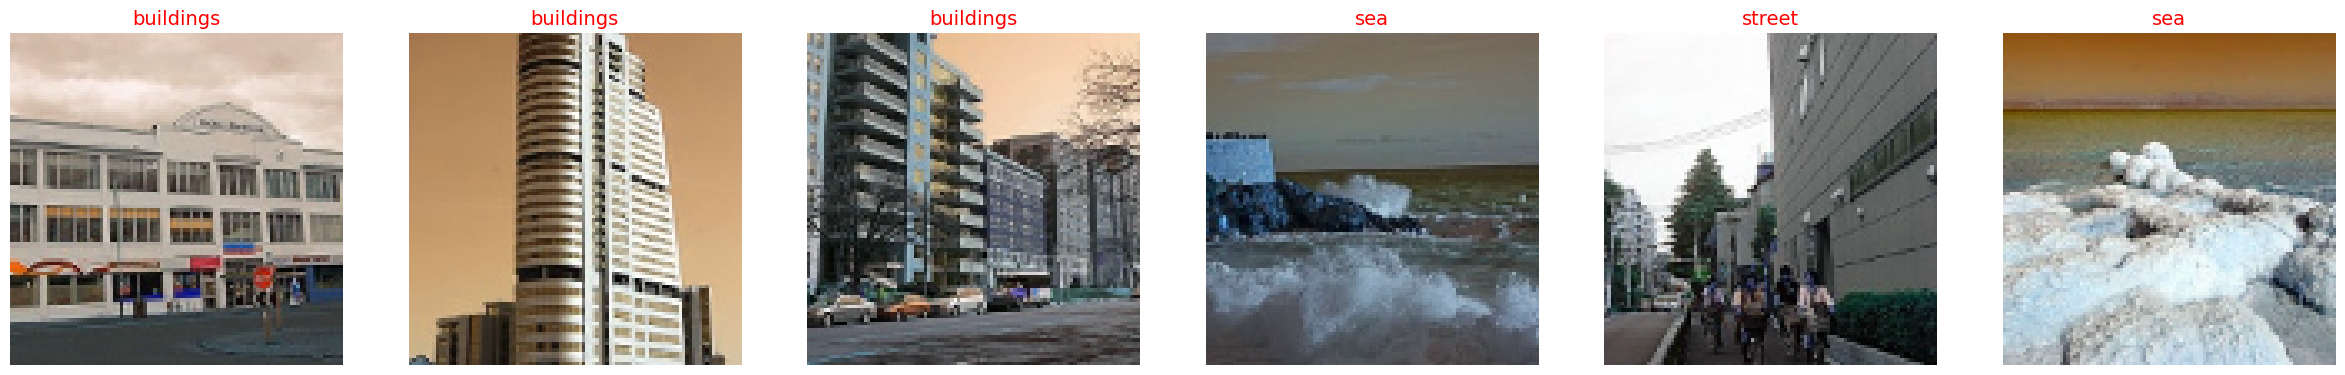

In [8]:
# Visualize some samples
def visualize_sample_image(X, y, name):
    print('-' * 77 + f' {name} Data ' + '-' * 77)
    plt.figure(figsize = (30, 40))
    for n, i in enumerate(list(np.random.randint(0, len(X), 6))):
        plt.subplot(6, 6, n+1)
        plt.imshow(X[i])
        plt.axis('off')
        if name != 'Prediction':
            plt.title(get_name(y[i]), fontdict = {'fontsize': 14, 'color': 'red'})

visualize_sample_image(X_train, y_train, name = 'Traning')

----------------------------------------------------------------------------- Test Data -----------------------------------------------------------------------------


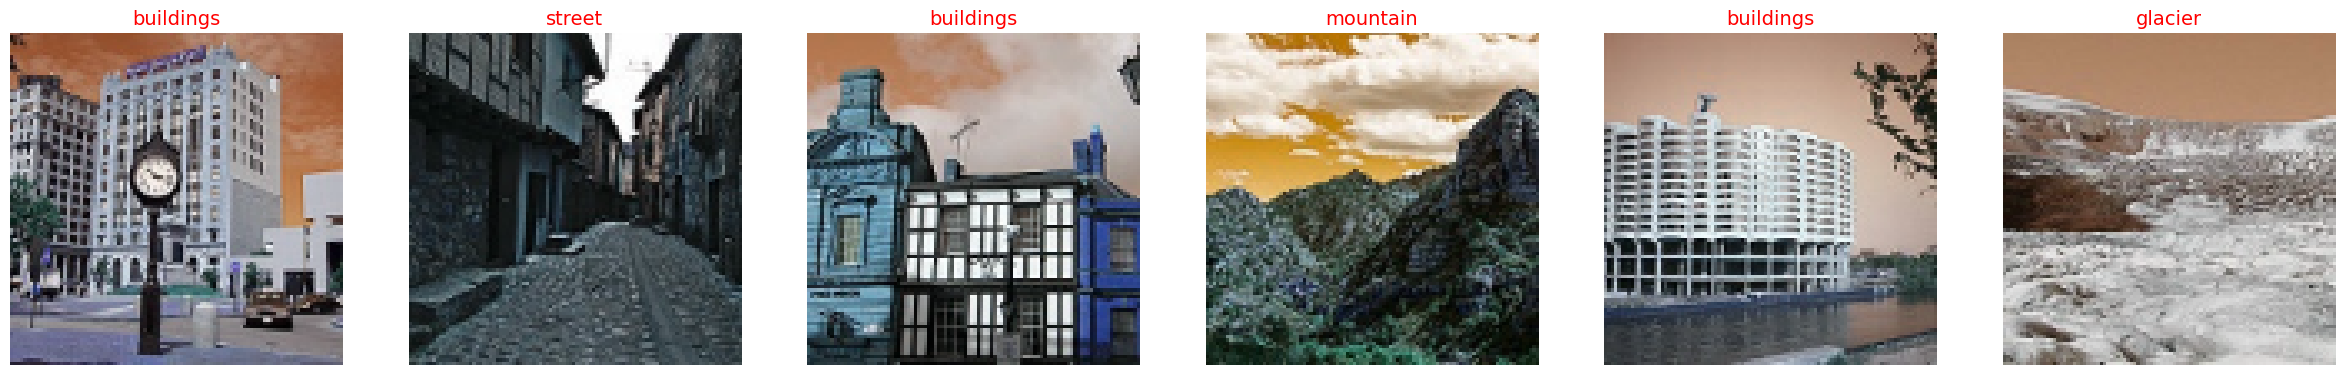

In [9]:
visualize_sample_image(X_test, y_test, name = 'Test')

----------------------------------------------------------------------------- Prediction Data -----------------------------------------------------------------------------


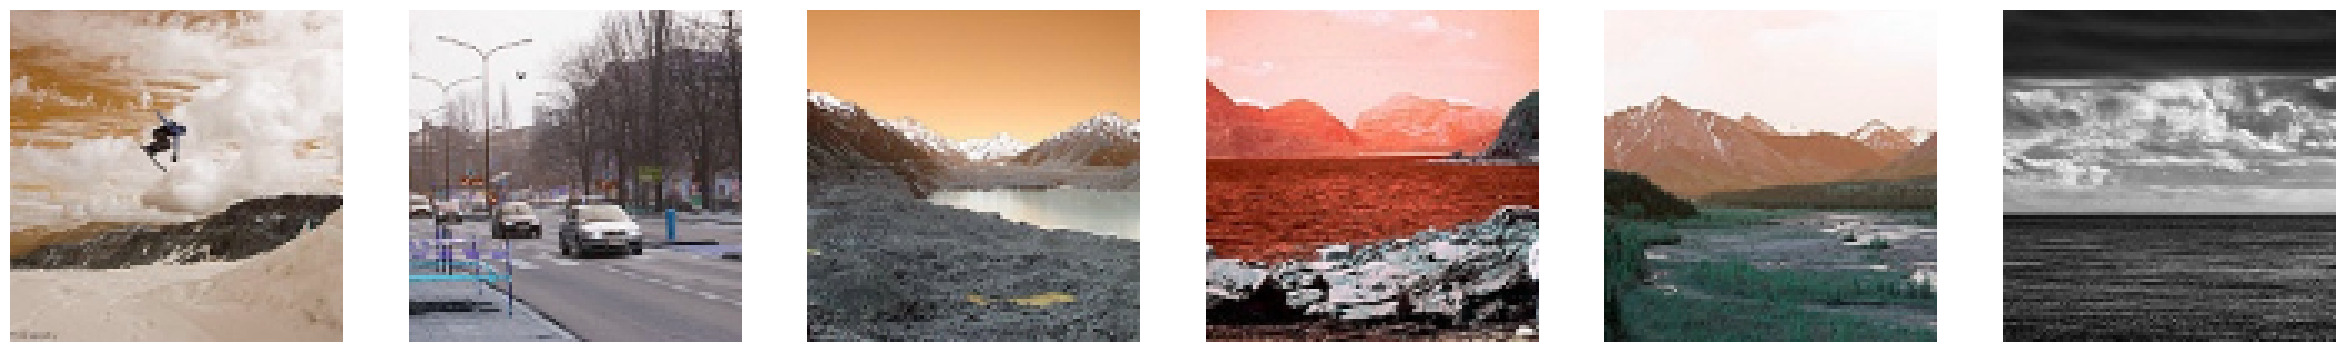

In [10]:
visualize_sample_image(X_pred, None, name = 'Prediction')

In [11]:
# (number of picture, height, width, channel)
X_train, y_train = np.array(X_train) , np.array(y_train)
X_test, y_test = np.array(X_test) , np.array(y_test)
X_pred  = np.array(X_pred)

print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')
print(f'X_pred shape  is {X_pred.shape}')

X_train shape  is (14034, 100, 100, 3)
X_test shape  is (3000, 100, 100, 3)
y_train shape  is (14034,)
y_test shape  is (3000,)
X_pred shape  is (7301, 100, 100, 3)


2. Model Architecture:
* Design a CNN model with at least 3 convolutional layers, followed by
pooling layers and fully connected (dense) layers.
* Experiment with different kernel sizes, activation functions (such as
ReLU), and pooling strategies (max-pooling or average pooling).
* Implement batch normalization and dropout techniques to improve the
generalization of your model.

In [12]:
model = keras.models.Sequential([
    keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(3, 3),
    keras.layers.Dropout(0.3),  # Add dropout layer

    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(3, 3),
    keras.layers.Dropout(0.3),  # Add dropout layer

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Add L2 regularization
    keras.layers.Dropout(0.4),  # Add dropout layer
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(6, activation='softmax')
])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 256)         │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 541,398 (2.07 MB)

 Trainable params: 541,110 (2.06 MB)

 Non-trainable params: 288 (1.12 KB)

None


3. Model Training:
* Split the dataset into training and test sets.

* Compile the model using an appropriate loss function (categorical cross-
entropy) and an optimizer (such as Adam or SGD).

* Train the model for a sufficient number of epochs, monitoring the training
and validation accuracy.

5. Optimization :
* Experiment with data augmentation techniques (rotation, flipping,
zooming) to further improve the model’s performance.
* Fine-tune hyperparameters like learning rate, batch size, and the number
of filters in each layer.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  # Adjust random_state as needed
)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to training data
datagen.fit(X_train)

# Fine-tune learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the fine-tuned optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune batch size and epochs
batch_size = 64
epochs = 25

# Create data generators for training and validation sets
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

# Train the model using augmented data and separate validation data
history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator  # Use validation_data instead of validation_split
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 99s 419ms/step - accuracy: 0.2241 - loss: 2.6118 - val_accuracy: 0.3926 - val_loss: 1.7103
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.3956 - loss: 1.7047 - val_accuracy: 0.5034 - val_loss: 1.5329
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.4697 - loss: 1.5270 - val_accuracy: 0.5251 - val_loss: 1.4214
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 293ms/step - accuracy: 0.5210 - loss: 1.4111 - val_accuracy: 0.4703 - val_loss: 1.4867
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 274ms/step - accuracy: 0.5381 - loss: 1.3800 - val_accuracy: 0.5230 - val_loss: 1.4046
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - accuracy: 0.5386 - loss: 1.3438 - val_accuracy: 0.5333 - val_loss: 1.4205
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 280ms/step - accuracy: 0.5638 - loss: 1.3109 - val_accuracy: 0.5461 - val_loss: 1.3295
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 275ms/step - accuracy: 0.5767 - loss: 1.2683 - val

4. Evaluation:
* Evaluate the trained model on the test set and report the accuracy.
* Plot the training and validation accuracy/loss curves to visualize the
model's performance.
* Display the confusion matrix for the test set to analyze misclassified
samples.

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss is {}'.format(loss))
print('Test Accuracy is {}'.format(accuracy ))

y_test_pred = model.predict(X_test)
print(f'Prediction Shape is {y_test_pred.shape}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.6591 - loss: 1.0284
Test Loss is 1.0368893146514893
Test Accuracy is 0.684333324432373
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Prediction Shape is (3000, 6)


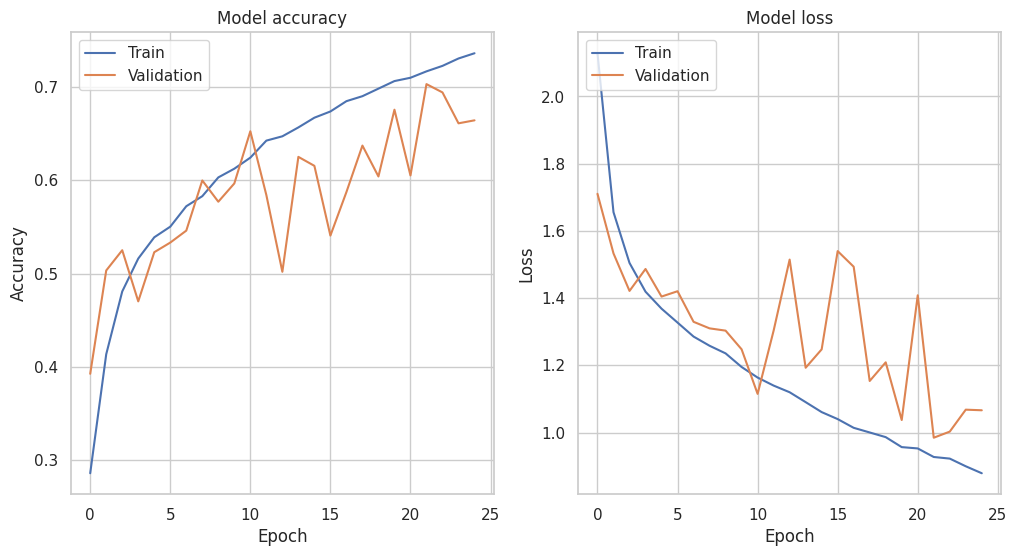

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

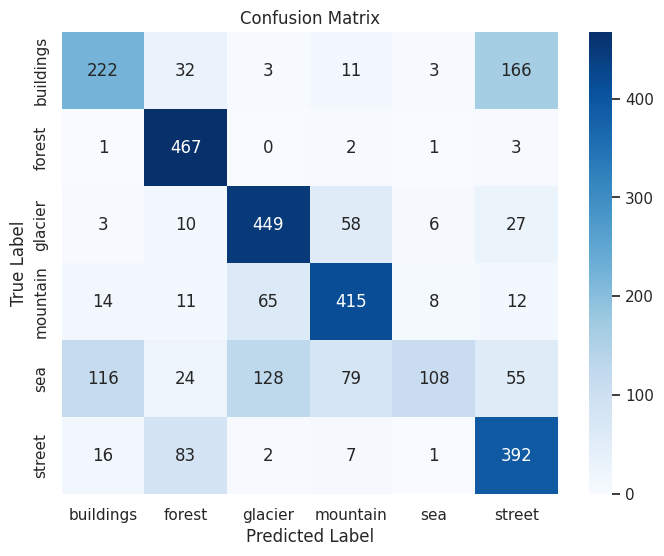

In [16]:
# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_test_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(code.keys()), yticklabels=list(code.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

###Inferences:

1. The dataset is well-distributed with approximately 14,000 training images, 3,000 test images, and 7,300 prediction images across 6 categories (buildings, forest, glacier, mountain, sea, street).

2. Most images are of size (150,150,3), with a few variations in height indicating some inconsistency in the original dataset.

3. Images were successfully resized to (100,100,3) for uniformity and model training efficiency.

4. The code structure suggests a sequential CNN model with multiple convolutional layers, batch normalization, and dropout for regularization.
5. The model training history shows improvement in accuracy from ~22% to ~73% over 25 epochs.

6. The validation accuracy peaked at around 70% but showed some fluctuation, indicating potential overfitting.

7. The confusion matrix reveals strong diagonal elements, suggesting good classification performance for most categories.

8. Data augmentation techniques were implemented to improve model generalization.

9. The learning rate of 0.0001 and batch size of 64 were chosen for optimization.

10. The model architecture includes regularization techniques (L2, dropout) to combat overfitting.